In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torch.autograd import Variable
from torchsummary import summary
from tqdm import tqdm

C:\Users\andyc\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data function

In [2]:
def get_mnist_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
    ])
    train_mnist = torchvision.datasets.MNIST(root='/kaggle/temp', train=True, download=True, transform=transform)
    test_mnist = torchvision.datasets.MNIST(root='/kaggle/temp', train=False, download=True, transform=transform)
    train_fmnist = torchvision.datasets.FashionMNIST(root='/kaggle/temp', train=True, download=True, transform=transform)
    test_fmnist = torchvision.datasets.FashionMNIST(root='/kaggle/temp', train=False, download=True, transform=transform)
    
    # 建立 DataLoader（MNIST）
    train_loader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader_mnist = DataLoader(test_mnist, batch_size=batch_size, shuffle=False, num_workers=2)

    # 建立 DataLoader（FashionMNIST）
    train_loader_fmnist = DataLoader(train_fmnist, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader_fmnist = DataLoader(test_fmnist, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist

# 定義 VGG Block
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super(VGGBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        if batch_norm:
            layers.insert(1, nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# 修改後的 VGG-16
class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256, 512, batch_norm=batch_norm)

        # 計算 Linear 層的輸入維度 (512 * 2 * 2)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### VGG model

In [3]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

### ResNet

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, input_channels=3):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        model_url = model_urls[arch]
        state_dict = load_state_dict_from_url(model_url,
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f9561.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d1f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed6d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4526.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

### CNN

In [25]:
class SimpleCNN_GELU(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(SimpleCNN_GELU, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.gelu1 = nn.GELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gelu2 = nn.GELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, num_classes)  # 假設輸入是 28x28

    def forward(self, x):
        x = self.conv1(x)
        x = self.gelu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.gelu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc(x)
        return x

### FGSM function

In [4]:
def fgsm_attack(model, images, device, labels, epsilon):
    """ 使用 FGSM 方法生成對抗樣本 """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    
    # 生成對抗樣本
    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)  # 限制到 [0,1] 範圍
    return adv_images

In [5]:
def perturb(imgs, eps, data_grads):
    # Collect the element-wise sign of the data gradient
    sign_data_grads = data_grads.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    adv_imgs = imgs + eps * sign_data_grads
    # Adding clipping to maintain [0,1] range
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    # Return the perturbed image
    return adv_imgs

def new_fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds

### PGD function

In [5]:
def pgd_attack(model, images, device, labels, epsilon, alpha, num_iter):
    """ 使用 PGD 方法生成對抗樣本 """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()

    for _ in range(num_iter):
        adv_images = adv_images.detach().clone()  # 創建新的葉節點
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        # 生成對抗樣本
        adv_images = adv_images + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - images, -epsilon, epsilon)  # 限制擾動範圍
        adv_images = torch.clamp(images + perturbation, 0, 1)  # 限制到 [0,1]

    return adv_images

In [7]:
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds

### Convolutional auto-encoder model

In [6]:
class ConvAutoencoder_GELU(nn.Module):
    def __init__(self, device, z_dim=10):
        super().__init__()
        self.device = device

        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.GELU()
        )

        ## Flatten Layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ## Linear Section
        self.encoder_linear = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.GELU(),
            nn.Linear(128, z_dim),
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.GELU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.GELU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_convt2d = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.GELU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        ## Encode the image to latent space
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        ## Add random gaussian noise to latent encoding
        if self.training:
            noise = torch.randn(x.shape).to(self.device)
            x = x + noise

        ## Decode the latent encoding back to reconstructed image
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        x = torch.sigmoid(x)
                
        return x

### self-attention layer

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, height * width, channels) #修改value的shape
        attention = torch.matmul(query, key)
        attention = nn.functional.softmax(attention, dim=-1)
        out = torch.matmul(attention, value).view(batch_size, channels, height, width)
        return self.gamma * out + x

In [8]:
class ConvSelfAttentionAutoencoder(nn.Module):
    def __init__(self, device, z_dim=10):
        super(ConvSelfAttentionAutoencoder, self).__init__()
        self.device = device

        # Encoder
        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.GELU(),
            SelfAttention(32) # 加入 Self-Attention
        )

        # Flatten Layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear Section
        self.encoder_linear = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.GELU(),
            nn.Linear(128, z_dim),
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.GELU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.GELU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_convt2d = nn.Sequential(
            SelfAttention(32), # 加入 Self-Attention
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.GELU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # Encode the image to latent space
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        # Add random gaussian noise to latent encoding
        if self.training:
            noise = torch.randn(x.shape).to(self.device)
            x = x + noise

        # Decode the latent encoding back to reconstructed image
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        x = torch.sigmoid(x)

        return x

### Function to train VGG

In [9]:
def train_model(model, train_loader, test_loader, save_name, num_epochs=10, lr=0.001, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 定義 loss function 和 optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0.0  # 紀錄最佳準確率
    history_loss = {"train": [], "test": []}
    history_accuracy = {"train": [], "test": []}
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        # 訓練
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        history_loss["train"].append(total_loss / len(train_loader))
        history_accuracy["train"].append(train_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

        # 測試
        model.eval()
        correct, total = 0, 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = 100 * correct / total
        history_loss["test"].append(test_loss / len(test_loader))
        history_accuracy["test"].append(test_acc)
        print(f"Test Acc: {test_acc:.2f}%\n")

        # 儲存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_"+save_name+".pth")

    print(f"Training finished. Best Test Acc: {best_acc:.2f}%")
    # Plot loss
    plt.title("Loss")
    for split in ["train", "test"]:
        plt.plot(history_loss[split], label=split)
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.title("Accuracy")
    for split in ["train", "test"]:
        plt.plot(history_accuracy[split], label=split)
    plt.legend()
    plt.show()

### Function to train ResNet

In [9]:
def train_and_validate_RESNET(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, dataset_name):
    """
    訓練和驗證模型。

    Args:
        model (nn.Module): 要訓練的模型。
        train_loader (DataLoader): 訓練數據的 DataLoader。
        val_loader (DataLoader): 驗證數據的 DataLoader。
        criterion (nn.Module): 損失函數。
        optimizer (optim.Optimizer): 優化器。
        device (torch.device): 模型運行的設備。
        num_epochs (int): 訓練的 epoch 數量。
        dataset_name (str): 數據集名稱 (用於打印日誌)。
    """
    for epoch in range(num_epochs):
        # 訓練
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training on {dataset_name})")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=f"{train_loss / total_train:.4f}", acc=f"{100 * train_correct / total_train:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss ({dataset_name}): {train_loss / total_train:.4f}, Train Accuracy: {100 * train_correct / total_train:.2f}%')

        # 驗證
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation on {dataset_name})")
            for images, labels in progress_bar_val:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                progress_bar_val.set_postfix(loss=f"{val_loss / total_val:.4f}", acc=f"{100 * val_correct / total_val:.2f}%")

        val_accuracy = 100 * val_correct / total_val
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss ({dataset_name}): {val_loss / total_val:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return model.state_dict()

### Function to train CNN

In [26]:
def train_and_validate_cnn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, dataset_name):
    """
    訓練和驗證 CNN 模型。

    Args:
        model (nn.Module): 要訓練的 CNN 模型。
        train_loader (DataLoader): 訓練數據的 DataLoader。
        val_loader (DataLoader): 驗證數據的 DataLoader。
        criterion (nn.Module): 損失函數。
        optimizer (optim.Optimizer): 優化器。
        device (torch.device): 模型運行的設備。
        num_epochs (int): 訓練的 epoch 數量。
        dataset_name (str): 數據集名稱 (用於打印日誌)。
    """
    for epoch in range(num_epochs):
        # 訓練
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training on {dataset_name})")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=f"{train_loss / total_train:.4f}", acc=f"{100 * train_correct / total_train:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss ({dataset_name}): {train_loss / total_train:.4f}, Train Accuracy: {100 * train_correct / total_train:.2f}%')

        # 驗證
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation on {dataset_name})")
            for images, labels in progress_bar_val:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                progress_bar_val.set_postfix(loss=f"{val_loss / total_val:.4f}", acc=f"{100 * val_correct / total_val:.2f}%")

        val_accuracy = 100 * val_correct / total_val
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss ({dataset_name}): {val_loss / total_val:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return model.state_dict()

### Function for adversarial attacks

In [22]:
def evaluate_adversarial_attack(model, test_loader, device, attack_type="FGSM", epsilon=0.3, alpha=0.01, num_iter=40):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad_(True)
        # 生成對抗樣本
        if attack_type == "FGSM":
            adv_images = fgsm_attack(model, images, device, labels, epsilon)
        elif attack_type == "PGD":
            adv_images = pgd_attack(model, images, device, labels, epsilon, alpha, num_iter)
        else:
            raise ValueError("Invalid attack type. Choose 'FGSM' or 'PGD'.")

        # 測試對抗樣本的準確率
        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"{attack_type} Attack | Epsilon: {epsilon} | Accuracy: {acc:.2f}%")

In [12]:
def generate_adversarial_samples(model, data_loader, device, attack_type="FGSM", epsilon=0.3, alpha=0.01, num_iter=40):
    model.to(device)
    model.eval()
    adversarial_samples = []
    original_samples = []
    labels_list = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # 生成對抗樣本
        if attack_type == "FGSM":
            adv_images = fgsm_attack(model, images, device, labels, epsilon)
        elif attack_type == "PGD":
            adv_images = pgd_attack(model, images, device, labels, epsilon, alpha, num_iter)
        else:
            raise ValueError("Invalid attack type. Choose 'FGSM' or 'PGD'.")

        adversarial_samples.append(adv_images.cpu())
        original_samples.append(images.cpu())
        labels_list.append(labels.cpu())

    adversarial_samples = torch.cat(adversarial_samples, dim=0)
    original_samples = torch.cat(original_samples, dim=0)
    labels_list = torch.cat(labels_list, dim=0)
    return adversarial_samples, original_samples, labels_list

### Function for training convolutional auto-encoder

In [10]:
class EarlyStopping:
    def __init__(self, tolerance=2, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping()
def load_checkpoint(checkpoint):
    convAE.load_state_dict(checkpoint['convAE_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['train_losses'], checkpoint['val_losses']

def save_checkpoint(checkpoint, model_path):
    torch.save(checkpoint, model_path)

In [11]:
def train(model, num_epochs, attack_type, train_loader, val_loader, device, load_model=False, file_path='trained_autoencoder.pth'):
    train_losses, val_losses = [], []
    if load_model:
        model.load_state_dict(torch.load(file_path, map_location=device))  # 確保模型載入到正確的裝置
        print("Loaded pre-trained model ...")
    model.to(device)
    start_epoch = len(train_losses)
    start_time = time.time()

    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        for images, labels in train_loader:
            batch_size = images.shape[0]  # 使用 images.shape[0] 而不是 imgs.shape[0]
            images, labels = Variable(images.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == "fgsm":  # 替換全形空格
                adv_imgs = fgsm_attack(model, images, device, labels, 0.6)
            else:
                adv_imgs = pgd_attack(model, images, device, labels, 0.15, 1, 40)

            train_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(images, rec_imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        for images, labels in val_loader:
            batch_size = images.shape[0]  # 使用 images.shape[0] 而不是 imgs.shape[0]
            images, labels = Variable(images.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs = fgsm_attack(model, images, device, labels, 0.6)
            else:
                adv_imgs = pgd_attack(model, images, device, labels, 0.15, 1, 40)

            val_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(images, rec_imgs)
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * batch_size

        train_loss, val_loss = train_loss / train_count, val_loss / val_count

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Time_taken: {(time.time()-start_time)/60:.2f} mins')
        checkpoint = {
            'convAE_state_dict': convAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses, 'val_losses': val_losses
        }
        torch.save(checkpoint, file_path)
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("Early Stopping criteria satisfied")
            break

    # 繪製訓練和驗證損失
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()
    plt.show()
    plt.close()

In [12]:
def train_CSAAE(model, num_epochs, attack_type, train_loader, val_loader, device, load_model=False, file_path='trained_self-attention_autoencoder.pth'):
    train_losses, val_losses = [], []
    if load_model:
        model.load_state_dict(torch.load(file_path, map_location=device))  # 確保模型載入到正確的裝置
        print("Loaded pre-trained model ...")
    model.to(device)
    start_epoch = len(train_losses)
    start_time = time.time()

    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        for images, labels in train_loader:
            batch_size = images.shape[0]  # 使用 images.shape[0] 而不是 imgs.shape[0]
            images, labels = Variable(images.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == "fgsm":  # 替換全形空格
                adv_imgs = fgsm_attack(model, images, device, labels, 0.6)
            else:
                adv_imgs = pgd_attack(model, images, device, labels, 0.15, 1, 40)

            train_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = CSAAE.forward(adv_imgs)
            loss = criterion(images, rec_imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        for images, labels in val_loader:
            batch_size = images.shape[0]  # 使用 images.shape[0] 而不是 imgs.shape[0]
            images, labels = Variable(images.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs = fgsm_attack(model, images, device, labels, 0.6)
            else:
                adv_imgs = pgd_attack(model, images, device, labels, 0.15, 1, 40)

            val_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = CSAAE.forward(adv_imgs)
            loss = criterion(images, rec_imgs)
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * batch_size

        train_loss, val_loss = train_loss / train_count, val_loss / val_count

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Time_taken: {(time.time()-start_time)/60:.2f} mins')
        checkpoint = {
            'CSAAE_state_dict': CSAAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses, 'val_losses': val_losses
        }
        torch.save(checkpoint, file_path)
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("Early Stopping criteria satisfied")
            break

    # 繪製訓練和驗證損失
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()
    plt.show()
    plt.close()

### Train VGG

Epoch [1/10] | Loss: 0.6833 | Train Acc: 74.48%
Test Acc: 97.89%

Epoch [2/10] | Loss: 0.0726 | Train Acc: 97.98%
Test Acc: 98.73%

Epoch [3/10] | Loss: 0.0523 | Train Acc: 98.67%
Test Acc: 98.91%

Epoch [4/10] | Loss: 0.0424 | Train Acc: 98.91%
Test Acc: 98.85%

Epoch [5/10] | Loss: 0.0402 | Train Acc: 98.96%
Test Acc: 98.93%

Epoch [6/10] | Loss: 0.0372 | Train Acc: 99.10%
Test Acc: 99.19%

Epoch [7/10] | Loss: 0.0296 | Train Acc: 99.25%
Test Acc: 98.87%

Epoch [8/10] | Loss: 0.0297 | Train Acc: 99.24%
Test Acc: 98.85%

Epoch [9/10] | Loss: 0.0346 | Train Acc: 99.14%
Test Acc: 99.14%

Epoch [10/10] | Loss: 0.0270 | Train Acc: 99.34%
Test Acc: 98.87%

Training finished. Best Test Acc: 99.19%


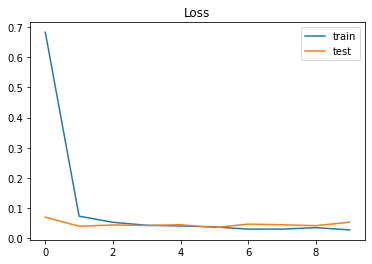

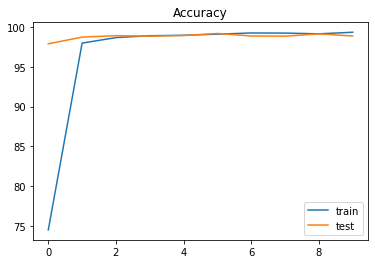

Epoch [1/10] | Loss: 0.8565 | Train Acc: 67.31%
Test Acc: 84.41%

Epoch [2/10] | Loss: 0.3565 | Train Acc: 87.22%
Test Acc: 87.52%

Epoch [3/10] | Loss: 0.2955 | Train Acc: 89.52%
Test Acc: 90.12%

Epoch [4/10] | Loss: 0.2583 | Train Acc: 90.75%
Test Acc: 90.87%

Epoch [5/10] | Loss: 0.2276 | Train Acc: 91.98%
Test Acc: 90.64%

Epoch [6/10] | Loss: 0.2101 | Train Acc: 92.41%
Test Acc: 91.83%

Epoch [7/10] | Loss: 0.1916 | Train Acc: 93.12%
Test Acc: 92.26%

Epoch [8/10] | Loss: 0.1764 | Train Acc: 93.66%
Test Acc: 90.93%

Epoch [9/10] | Loss: 0.1662 | Train Acc: 94.06%
Test Acc: 91.97%

Epoch [10/10] | Loss: 0.1559 | Train Acc: 94.47%
Test Acc: 91.80%

Training finished. Best Test Acc: 92.26%


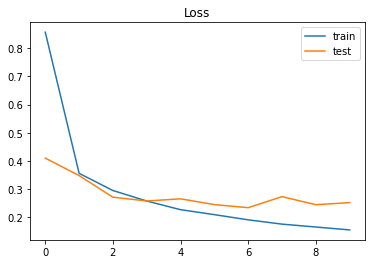

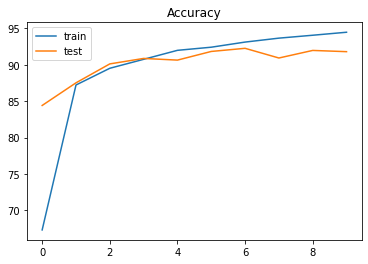

In [38]:
# 載入資料
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()

# 訓練 VGG-16 on MNIST
model_mnist = VGG16(input_size=(1, 32, 32), num_classes=10)
train_model(model_mnist, train_loader_mnist, test_loader_mnist, save_name='VGG16_mnist', num_epochs=10, lr=0.001)

# 訓練 VGG-16 on FashionMNIST
model_fmnist = VGG16(input_size=(1, 32, 32), num_classes=10)
train_model(model_fmnist, train_loader_fmnist, test_loader_fmnist, save_name='VGG16_fmnist', num_epochs=10, lr=0.001)

In [37]:
if __name__ == '__main__':
    # 設定超參數
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10

    # --- 訓練 MNIST ---
    print("\n--- Training on MNIST ---")
    train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()
    
    model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
    criterion_mnist = nn.CrossEntropyLoss()
    optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=learning_rate)

    mnist_weights = train_and_validate_RESNET(model_mnist, train_loader_mnist, test_loader_mnist, criterion_mnist, optimizer_mnist, device, num_epochs, "MNIST")
    torch.save(mnist_weights, 'resnet18_mnist.pth')
    print("Trained ResNet18 model on MNIST saved to resnet18_mnist.pth")

    # --- 訓練 FMNIST ---
    print("\n--- Training on Fashion-MNIST ---")
    

    model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
    criterion_fmnist = nn.CrossEntropyLoss()
    optimizer_fmnist = optim.Adam(model_fmnist.parameters(), lr=learning_rate)

    fmnist_weights = train_and_validate_RESNET(model_fmnist, train_loader_fmnist, test_loader_fmnist, criterion_fmnist, optimizer_fmnist, device, num_epochs, "Fashion-MNIST")
    torch.save(fmnist_weights, 'resnet18_fmnist.pth')
    print("Trained ResNet18 model on Fashion-MNIST saved to resnet18_fmnist.pth")


--- Training on MNIST ---


Epoch 1/10 (Training on MNIST): 100%|██████████| 469/469 [00:34<00:00, 13.78it/s, acc=96.36%, loss=0.1197]


Epoch [1/10], Train Loss (MNIST): 0.1197, Train Accuracy: 96.36%


Epoch 1/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 20.84it/s, acc=91.68%, loss=0.2955]


Epoch [1/10], Validation Loss (MNIST): 0.2955, Validation Accuracy: 91.68%


Epoch 2/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.10it/s, acc=98.35%, loss=0.0546]


Epoch [2/10], Train Loss (MNIST): 0.0546, Train Accuracy: 98.35%


Epoch 2/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 22.92it/s, acc=98.74%, loss=0.0461]


Epoch [2/10], Validation Loss (MNIST): 0.0461, Validation Accuracy: 98.74%


Epoch 3/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.09it/s, acc=98.78%, loss=0.0406]


Epoch [3/10], Train Loss (MNIST): 0.0406, Train Accuracy: 98.78%


Epoch 3/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 20.72it/s, acc=98.09%, loss=0.0654]


Epoch [3/10], Validation Loss (MNIST): 0.0654, Validation Accuracy: 98.09%


Epoch 4/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.92it/s, acc=98.97%, loss=0.0333]


Epoch [4/10], Train Loss (MNIST): 0.0333, Train Accuracy: 98.97%


Epoch 4/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.69it/s, acc=98.98%, loss=0.0306]


Epoch [4/10], Validation Loss (MNIST): 0.0306, Validation Accuracy: 98.98%


Epoch 5/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.91it/s, acc=99.14%, loss=0.0274]


Epoch [5/10], Train Loss (MNIST): 0.0274, Train Accuracy: 99.14%


Epoch 5/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.66it/s, acc=99.05%, loss=0.0318]


Epoch [5/10], Validation Loss (MNIST): 0.0318, Validation Accuracy: 99.05%


Epoch 6/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.02it/s, acc=99.22%, loss=0.0264]


Epoch [6/10], Train Loss (MNIST): 0.0264, Train Accuracy: 99.22%


Epoch 6/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 20.43it/s, acc=98.99%, loss=0.0367]


Epoch [6/10], Validation Loss (MNIST): 0.0367, Validation Accuracy: 98.99%


Epoch 7/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.80it/s, acc=99.33%, loss=0.0234]


Epoch [7/10], Train Loss (MNIST): 0.0234, Train Accuracy: 99.33%


Epoch 7/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.36it/s, acc=99.02%, loss=0.0283]


Epoch [7/10], Validation Loss (MNIST): 0.0283, Validation Accuracy: 99.02%


Epoch 8/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.93it/s, acc=99.44%, loss=0.0190]


Epoch [8/10], Train Loss (MNIST): 0.0190, Train Accuracy: 99.44%


Epoch 8/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 22.02it/s, acc=99.16%, loss=0.0314]


Epoch [8/10], Validation Loss (MNIST): 0.0314, Validation Accuracy: 99.16%


Epoch 9/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.13it/s, acc=99.43%, loss=0.0191]


Epoch [9/10], Train Loss (MNIST): 0.0191, Train Accuracy: 99.43%


Epoch 9/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.67it/s, acc=98.73%, loss=0.0439]


Epoch [9/10], Validation Loss (MNIST): 0.0439, Validation Accuracy: 98.73%


Epoch 10/10 (Training on MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.12it/s, acc=99.53%, loss=0.0165]


Epoch [10/10], Train Loss (MNIST): 0.0165, Train Accuracy: 99.53%


Epoch 10/10 (Validation on MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.84it/s, acc=99.26%, loss=0.0261]


Epoch [10/10], Validation Loss (MNIST): 0.0261, Validation Accuracy: 99.26%
Trained ResNet18 model on MNIST saved to resnet18_mnist.pth

--- Training on Fashion-MNIST ---


Epoch 1/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.85it/s, acc=84.71%, loss=0.4130]


Epoch [1/10], Train Loss (Fashion-MNIST): 0.4130, Train Accuracy: 84.71%


Epoch 1/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.99it/s, acc=87.72%, loss=0.3313]


Epoch [1/10], Validation Loss (Fashion-MNIST): 0.3313, Validation Accuracy: 87.72%


Epoch 2/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:32<00:00, 14.23it/s, acc=89.30%, loss=0.2905]


Epoch [2/10], Train Loss (Fashion-MNIST): 0.2905, Train Accuracy: 89.30%


Epoch 2/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.87it/s, acc=88.68%, loss=0.3139]


Epoch [2/10], Validation Loss (Fashion-MNIST): 0.3139, Validation Accuracy: 88.68%


Epoch 3/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.85it/s, acc=90.56%, loss=0.2553]


Epoch [3/10], Train Loss (Fashion-MNIST): 0.2553, Train Accuracy: 90.56%


Epoch 3/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.71it/s, acc=90.08%, loss=0.2739]


Epoch [3/10], Validation Loss (Fashion-MNIST): 0.2739, Validation Accuracy: 90.08%


Epoch 4/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.87it/s, acc=91.48%, loss=0.2291]


Epoch [4/10], Train Loss (Fashion-MNIST): 0.2291, Train Accuracy: 91.48%


Epoch 4/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.72it/s, acc=89.40%, loss=0.2747]


Epoch [4/10], Validation Loss (Fashion-MNIST): 0.2747, Validation Accuracy: 89.40%


Epoch 5/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.94it/s, acc=92.14%, loss=0.2086]


Epoch [5/10], Train Loss (Fashion-MNIST): 0.2086, Train Accuracy: 92.14%


Epoch 5/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 21.33it/s, acc=90.08%, loss=0.2721]


Epoch [5/10], Validation Loss (Fashion-MNIST): 0.2721, Validation Accuracy: 90.08%


Epoch 6/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.13it/s, acc=92.65%, loss=0.1962]


Epoch [6/10], Train Loss (Fashion-MNIST): 0.1962, Train Accuracy: 92.65%


Epoch 6/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 22.51it/s, acc=90.59%, loss=0.2548]


Epoch [6/10], Validation Loss (Fashion-MNIST): 0.2548, Validation Accuracy: 90.59%


Epoch 7/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:34<00:00, 13.75it/s, acc=93.27%, loss=0.1759]


Epoch [7/10], Train Loss (Fashion-MNIST): 0.1759, Train Accuracy: 93.27%


Epoch 7/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 20.75it/s, acc=90.68%, loss=0.2520]


Epoch [7/10], Validation Loss (Fashion-MNIST): 0.2520, Validation Accuracy: 90.68%


Epoch 8/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.16it/s, acc=93.96%, loss=0.1610]


Epoch [8/10], Train Loss (Fashion-MNIST): 0.1610, Train Accuracy: 93.96%


Epoch 8/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 22.53it/s, acc=90.92%, loss=0.2639]


Epoch [8/10], Validation Loss (Fashion-MNIST): 0.2639, Validation Accuracy: 90.92%


Epoch 9/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 14.10it/s, acc=94.10%, loss=0.1546]


Epoch [9/10], Train Loss (Fashion-MNIST): 0.1546, Train Accuracy: 94.10%


Epoch 9/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 22.58it/s, acc=89.27%, loss=0.3042]


Epoch [9/10], Validation Loss (Fashion-MNIST): 0.3042, Validation Accuracy: 89.27%


Epoch 10/10 (Training on Fashion-MNIST): 100%|██████████| 469/469 [00:33<00:00, 13.87it/s, acc=94.76%, loss=0.1355]


Epoch [10/10], Train Loss (Fashion-MNIST): 0.1355, Train Accuracy: 94.76%


Epoch 10/10 (Validation on Fashion-MNIST): 100%|██████████| 79/79 [00:03<00:00, 20.68it/s, acc=91.63%, loss=0.2466]

Epoch [10/10], Validation Loss (Fashion-MNIST): 0.2466, Validation Accuracy: 91.63%
Trained ResNet18 model on Fashion-MNIST saved to resnet18_fmnist.pth


In [13]:
def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc=f"測試 {dataset_name} 模型")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(acc=f"{100 * correct / total:.2f}%")

    accuracy = 100 * correct / total
    print(f"\n{dataset_name} 模型在測試集上的準確率: {accuracy:.2f}%")
    return accuracy

if __name__ == '__main__':
    # 設定超參數 (需要與訓練時保持一致)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    input_channels = 1

    # 載入數據集和 DataLoader
    train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders(batch_size=64) # 使用與訓練時相同的 batch_size (如果需要)

    # --- 測試 MNIST 模型 ---
    model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=input_channels).to(device)
    try:
        model_mnist.load_state_dict(torch.load('resnet18_mnist.pth', map_location=device))
        print("\n載入 MNIST 模型權重成功！")
        evaluate_model(model_mnist, test_loader_mnist, device, "MNIST")
    except FileNotFoundError:
        print("錯誤：找不到 'resnet18_mnist.pth' 文件。請檢查文件路徑。")

    # --- 測試 Fashion-MNIST 模型 ---
    model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=input_channels).to(device)
    try:
        model_fmnist.load_state_dict(torch.load('resnet18_fmnist.pth', map_location=device))
        print("\n載入 Fashion-MNIST 模型權重成功！")
        evaluate_model(model_fmnist, test_loader_fmnist, device, "Fashion-MNIST")
    except FileNotFoundError:
        print("錯誤：找不到 'resnet18_fmnist.pth' 文件。請檢查文件路徑。")


載入 MNIST 模型權重成功！


測試 MNIST 模型: 100%|██████████| 157/157 [00:14<00:00, 10.89it/s, acc=99.26%]



MNIST 模型在測試集上的準確率: 99.26%

載入 Fashion-MNIST 模型權重成功！


測試 Fashion-MNIST 模型: 100%|██████████| 157/157 [00:04<00:00, 33.08it/s, acc=91.63%]


Fashion-MNIST 模型在測試集上的準確率: 91.63%


In [27]:
if __name__ == '__main__':
    # 設定超參數
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    input_channels = 1  # MNIST 和 FMNIST 都是單通道灰度圖像

    # --- 訓練 MNIST ---
    print("\n--- Training on MNIST ---")
    transform_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST 的均值和標準差
    ])

    train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
    train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False, num_workers=4)

    model_mnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
    criterion_mnist = nn.CrossEntropyLoss()
    optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=learning_rate)

    mnist_weights = train_and_validate_cnn(model_mnist, train_loader_mnist, test_loader_mnist, criterion_mnist, optimizer_mnist, device, num_epochs, "MNIST")
    torch.save(mnist_weights, 'simple_cnn_gelu_mnist.pth')
    print("Trained SimpleCNN_GELU model on MNIST saved to simple_cnn_gelu_mnist.pth")

    # --- 訓練 FMNIST ---
    print("\n--- Training on Fashion-MNIST ---")
    transform_fmnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # FMNIST 的均值和標準差
    ])

    train_dataset_fmnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fmnist)
    test_dataset_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fmnist)
    train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader_fmnist = DataLoader(test_dataset_fmnist, batch_size=batch_size, shuffle=False, num_workers=4)

    model_fmnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
    criterion_fmnist = nn.CrossEntropyLoss()
    optimizer_fmnist = optim.Adam(model_fmnist.parameters(), lr=learning_rate)

    fmnist_weights = train_and_validate_cnn(model_fmnist, train_loader_fmnist, test_loader_fmnist, criterion_fmnist, optimizer_fmnist, device, num_epochs, "Fashion-MNIST")
    torch.save(fmnist_weights, 'simple_cnn_gelu_fmnist.pth')
    print("Trained SimpleCNN_GELU model on Fashion-MNIST saved to simple_cnn_gelu_fmnist.pth")


--- Training on MNIST ---


Epoch 1/10 (Training on MNIST): 100%|██████████| 938/938 [00:13<00:00, 71.47it/s, acc=96.11%, loss=0.1301] 


Epoch [1/10], Train Loss (MNIST): 0.1301, Train Accuracy: 96.11%


Epoch 1/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.30it/s, acc=98.31%, loss=0.0519] 


Epoch [1/10], Validation Loss (MNIST): 0.0519, Validation Accuracy: 98.31%


Epoch 2/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.38it/s, acc=98.63%, loss=0.0446] 


Epoch [2/10], Train Loss (MNIST): 0.0446, Train Accuracy: 98.63%


Epoch 2/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.54it/s, acc=98.93%, loss=0.0330] 


Epoch [2/10], Validation Loss (MNIST): 0.0330, Validation Accuracy: 98.93%


Epoch 3/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.33it/s, acc=99.03%, loss=0.0311] 


Epoch [3/10], Train Loss (MNIST): 0.0311, Train Accuracy: 99.03%


Epoch 3/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.98it/s, acc=98.80%, loss=0.0372] 


Epoch [3/10], Validation Loss (MNIST): 0.0372, Validation Accuracy: 98.80%


Epoch 4/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.51it/s, acc=99.26%, loss=0.0245] 


Epoch [4/10], Train Loss (MNIST): 0.0245, Train Accuracy: 99.26%


Epoch 4/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.22it/s, acc=98.96%, loss=0.0309] 


Epoch [4/10], Validation Loss (MNIST): 0.0309, Validation Accuracy: 98.96%


Epoch 5/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 72.64it/s, acc=99.42%, loss=0.0184] 


Epoch [5/10], Train Loss (MNIST): 0.0184, Train Accuracy: 99.42%


Epoch 5/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.82it/s, acc=98.78%, loss=0.0400] 


Epoch [5/10], Validation Loss (MNIST): 0.0400, Validation Accuracy: 98.78%


Epoch 6/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.62it/s, acc=99.52%, loss=0.0152] 


Epoch [6/10], Train Loss (MNIST): 0.0152, Train Accuracy: 99.52%


Epoch 6/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 48.19it/s, acc=99.09%, loss=0.0308] 


Epoch [6/10], Validation Loss (MNIST): 0.0308, Validation Accuracy: 99.09%


Epoch 7/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.94it/s, acc=99.65%, loss=0.0111] 


Epoch [7/10], Train Loss (MNIST): 0.0111, Train Accuracy: 99.65%


Epoch 7/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.06it/s, acc=99.05%, loss=0.0324] 


Epoch [7/10], Validation Loss (MNIST): 0.0324, Validation Accuracy: 99.05%


Epoch 8/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.66it/s, acc=99.64%, loss=0.0104] 


Epoch [8/10], Train Loss (MNIST): 0.0104, Train Accuracy: 99.64%


Epoch 8/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 48.61it/s, acc=99.04%, loss=0.0308] 


Epoch [8/10], Validation Loss (MNIST): 0.0308, Validation Accuracy: 99.04%


Epoch 9/10 (Training on MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.23it/s, acc=99.74%, loss=0.0073] 


Epoch [9/10], Train Loss (MNIST): 0.0073, Train Accuracy: 99.74%


Epoch 9/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 43.01it/s, acc=99.04%, loss=0.0368] 


Epoch [9/10], Validation Loss (MNIST): 0.0368, Validation Accuracy: 99.04%


Epoch 10/10 (Training on MNIST): 100%|██████████| 938/938 [00:13<00:00, 70.22it/s, acc=99.75%, loss=0.0072] 


Epoch [10/10], Train Loss (MNIST): 0.0072, Train Accuracy: 99.75%


Epoch 10/10 (Validation on MNIST): 100%|██████████| 157/157 [00:03<00:00, 45.56it/s, acc=99.23%, loss=0.0307] 


Epoch [10/10], Validation Loss (MNIST): 0.0307, Validation Accuracy: 99.23%
Trained SimpleCNN_GELU model on MNIST saved to simple_cnn_gelu_mnist.pth

--- Training on Fashion-MNIST ---


Epoch 1/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:13<00:00, 69.58it/s, acc=85.68%, loss=0.3980] 


Epoch [1/10], Train Loss (Fashion-MNIST): 0.3980, Train Accuracy: 85.68%


Epoch 1/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.45it/s, acc=88.43%, loss=0.3257] 


Epoch [1/10], Validation Loss (Fashion-MNIST): 0.3257, Validation Accuracy: 88.43%


Epoch 2/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 74.75it/s, acc=90.29%, loss=0.2676] 


Epoch [2/10], Train Loss (Fashion-MNIST): 0.2676, Train Accuracy: 90.29%


Epoch 2/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.75it/s, acc=89.57%, loss=0.2788] 


Epoch [2/10], Validation Loss (Fashion-MNIST): 0.2788, Validation Accuracy: 89.57%


Epoch 3/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 76.27it/s, acc=91.83%, loss=0.2264] 


Epoch [3/10], Train Loss (Fashion-MNIST): 0.2264, Train Accuracy: 91.83%


Epoch 3/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.28it/s, acc=90.59%, loss=0.2627] 


Epoch [3/10], Validation Loss (Fashion-MNIST): 0.2627, Validation Accuracy: 90.59%


Epoch 4/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.54it/s, acc=92.58%, loss=0.2027] 


Epoch [4/10], Train Loss (Fashion-MNIST): 0.2027, Train Accuracy: 92.58%


Epoch 4/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.10it/s, acc=90.90%, loss=0.2500] 


Epoch [4/10], Validation Loss (Fashion-MNIST): 0.2500, Validation Accuracy: 90.90%


Epoch 5/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.95it/s, acc=93.41%, loss=0.1820] 


Epoch [5/10], Train Loss (Fashion-MNIST): 0.1820, Train Accuracy: 93.41%


Epoch 5/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.76it/s, acc=91.40%, loss=0.2468] 


Epoch [5/10], Validation Loss (Fashion-MNIST): 0.2468, Validation Accuracy: 91.40%


Epoch 6/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 75.14it/s, acc=93.92%, loss=0.1659] 


Epoch [6/10], Train Loss (Fashion-MNIST): 0.1659, Train Accuracy: 93.92%


Epoch 6/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.39it/s, acc=91.71%, loss=0.2399] 


Epoch [6/10], Validation Loss (Fashion-MNIST): 0.2399, Validation Accuracy: 91.71%


Epoch 7/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 75.24it/s, acc=94.48%, loss=0.1529] 


Epoch [7/10], Train Loss (Fashion-MNIST): 0.1529, Train Accuracy: 94.48%


Epoch 7/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 47.15it/s, acc=91.07%, loss=0.2509] 


Epoch [7/10], Validation Loss (Fashion-MNIST): 0.2509, Validation Accuracy: 91.07%


Epoch 8/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 74.59it/s, acc=94.98%, loss=0.1391] 


Epoch [8/10], Train Loss (Fashion-MNIST): 0.1391, Train Accuracy: 94.98%


Epoch 8/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 44.20it/s, acc=91.19%, loss=0.2604] 


Epoch [8/10], Validation Loss (Fashion-MNIST): 0.2604, Validation Accuracy: 91.19%


Epoch 9/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.75it/s, acc=95.38%, loss=0.1283] 


Epoch [9/10], Train Loss (Fashion-MNIST): 0.1283, Train Accuracy: 95.38%


Epoch 9/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 48.19it/s, acc=91.42%, loss=0.2508] 


Epoch [9/10], Validation Loss (Fashion-MNIST): 0.2508, Validation Accuracy: 91.42%


Epoch 10/10 (Training on Fashion-MNIST): 100%|██████████| 938/938 [00:12<00:00, 73.80it/s, acc=95.72%, loss=0.1175] 


Epoch [10/10], Train Loss (Fashion-MNIST): 0.1175, Train Accuracy: 95.72%


Epoch 10/10 (Validation on Fashion-MNIST): 100%|██████████| 157/157 [00:03<00:00, 46.75it/s, acc=91.07%, loss=0.2774] 

Epoch [10/10], Validation Loss (Fashion-MNIST): 0.2774, Validation Accuracy: 91.07%
Trained SimpleCNN_GELU model on Fashion-MNIST saved to simple_cnn_gelu_fmnist.pth


In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"CUDA 可用，正在使用 GPU：{torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("CUDA 不可用，正在使用 CPU")

CUDA 可用，正在使用 GPU：NVIDIA GeForce RTX 4060 Laptop GPU


In [23]:
# 載入測試數據
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()

fgsm_epsilon = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 1.00, 1.50]
pgd_epsilon = [0.00, 0.05, 0.10, 0.15, 0.20, 0.30]
# 載入訓練好的模型
model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_mnist.load_state_dict(torch.load("resnet18_mnist.pth", map_location=device))
# 測試 FashionMNIST 在 FGSM 攻擊下的準確率
for epsilon in fgsm_epsilon:
    evaluate_adversarial_attack(model_mnist, test_loader_mnist, device, attack_type="FGSM", epsilon=epsilon)

# 測試 FashionMNIST 在 PGD 攻擊下的準確率
for epsilon in pgd_epsilon:
    evaluate_adversarial_attack(model_mnist, test_loader_mnist, device, attack_type="PGD", epsilon=epsilon, alpha=0.01, num_iter=40)

model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_fmnist.load_state_dict(torch.load("resnet18_fmnist.pth", map_location=device))
# 測試 FashionMNIST 在 FGSM 攻擊下的準確率
for epsilon in fgsm_epsilon:
    evaluate_adversarial_attack(model_fmnist, test_loader_fmnist, device, attack_type="FGSM", epsilon=epsilon)

# 測試 FashionMNIST 在 PGD 攻擊下的準確率
for epsilon in pgd_epsilon:
    evaluate_adversarial_attack(model_fmnist, test_loader_fmnist, device, attack_type="PGD", epsilon=epsilon, alpha=0.01, num_iter=40)

FGSM Attack | Epsilon: 0.0 | Accuracy: 99.26%
FGSM Attack | Epsilon: 0.1 | Accuracy: 69.60%
FGSM Attack | Epsilon: 0.2 | Accuracy: 12.46%
FGSM Attack | Epsilon: 0.3 | Accuracy: 2.36%
FGSM Attack | Epsilon: 0.4 | Accuracy: 1.60%
FGSM Attack | Epsilon: 0.5 | Accuracy: 1.49%
FGSM Attack | Epsilon: 0.6 | Accuracy: 1.55%
FGSM Attack | Epsilon: 0.7 | Accuracy: 1.77%
FGSM Attack | Epsilon: 1.0 | Accuracy: 2.33%
FGSM Attack | Epsilon: 1.5 | Accuracy: 2.33%
PGD Attack | Epsilon: 0.0 | Accuracy: 99.26%
PGD Attack | Epsilon: 0.05 | Accuracy: 88.20%
PGD Attack | Epsilon: 0.1 | Accuracy: 24.74%
PGD Attack | Epsilon: 0.15 | Accuracy: 0.89%
PGD Attack | Epsilon: 0.2 | Accuracy: 0.01%
PGD Attack | Epsilon: 0.3 | Accuracy: 0.00%
FGSM Attack | Epsilon: 0.0 | Accuracy: 91.63%
FGSM Attack | Epsilon: 0.1 | Accuracy: 11.74%
FGSM Attack | Epsilon: 0.2 | Accuracy: 3.23%
FGSM Attack | Epsilon: 0.3 | Accuracy: 3.48%
FGSM Attack | Epsilon: 0.4 | Accuracy: 4.68%
FGSM Attack | Epsilon: 0.5 | Accuracy: 6.17%
FGSM A

### Generate adversarial attacks

In [16]:
# 載入訓練好的模型
model_mnist = VGG16(input_size=(1, 32, 32), num_classes=10)
model_mnist.load_state_dict(torch.load("best_VGG16_mnist.pth", map_location=device))
model_fmnist = VGG16(input_size=(1, 32, 32), num_classes=10)
model_fmnist.load_state_dict(torch.load("best_VGG16_fmnist.pth", map_location=device))
# 載入測試數據
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()

# 生成 MNIST 的對抗樣本
adv_samples_mnist_fgsm, original_samples_mnist_fgsm, labels_mnist = generate_adversarial_samples(model_mnist, test_loader_mnist, device, attack_type="FGSM", epsilon=0.6)
adv_samples_mnist_pgd, original_samples_mnist_pgd, _ = generate_adversarial_samples(model_mnist, test_loader_mnist, device, attack_type="PGD", epsilon=0.15, alpha=1, num_iter=40)

# 生成 FashionMNIST 的對抗樣本
adv_samples_fmnist_fgsm, original_samples_fmnist_fgsm, labels_fmnist = generate_adversarial_samples(model_fmnist, test_loader_fmnist, device, attack_type="FGSM", epsilon=0.6)
adv_samples_fmnist_pgd, original_samples_fmnist_pgd, _ = generate_adversarial_samples(model_fmnist, test_loader_fmnist, device, attack_type="PGD", epsilon=0.15, alpha=1, num_iter=40)

# 分割為訓練集和測試集
adv_train_mnist_fgsm, adv_test_mnist_fgsm, original_train_mnist_fgsm, original_test_mnist_fgsm, train_labels_mnist_fgsm, test_labels_mnist_fgsm = train_test_split(adv_samples_mnist_fgsm, original_samples_mnist_fgsm, labels_mnist, test_size=0.2, random_state=42)
adv_train_mnist_pgd, adv_test_mnist_pgd, original_train_mnist_pgd, original_test_mnist_pgd, train_labels_mnist_pgd, test_labels_mnist_pgd = train_test_split(adv_samples_mnist_pgd, original_samples_mnist_pgd, labels_mnist, test_size=0.2, random_state=42)
adv_train_fmnist_fgsm, adv_test_fmnist_fgsm, original_train_fmnist_fgsm, original_test_fmnist_fgsm, train_labels_fmnist_fgsm, test_labels_fmnist_fgsm = train_test_split(adv_samples_fmnist_fgsm, original_samples_fmnist_fgsm, labels_fmnist, test_size=0.2, random_state=42)
adv_train_fmnist_pgd, adv_test_fmnist_pgd, original_train_fmnist_pgd, original_test_fmnist_pgd, train_labels_fmnist_pgd, test_labels_fmnist_pgd = train_test_split(adv_samples_fmnist_pgd, original_samples_fmnist_pgd, labels_fmnist, test_size=0.2, random_state=42)

# 儲存對抗樣本和原始資料
torch.save((adv_train_mnist_fgsm, original_train_mnist_fgsm, train_labels_mnist_fgsm), "adv_train_mnist_fgsm.pt")
torch.save((adv_test_mnist_fgsm, original_test_mnist_fgsm, test_labels_mnist_fgsm), "adv_test_mnist_fgsm.pt")
torch.save((adv_train_mnist_pgd, original_train_mnist_pgd, train_labels_mnist_pgd), "adv_train_mnist_pgd.pt")
torch.save((adv_test_mnist_pgd, original_test_mnist_pgd, test_labels_mnist_pgd), "adv_test_mnist_pgd.pt")
torch.save((adv_train_fmnist_fgsm, original_train_fmnist_fgsm, train_labels_fmnist_fgsm), "adv_train_fmnist_fgsm.pt")
torch.save((adv_test_fmnist_fgsm, original_test_fmnist_fgsm, test_labels_fmnist_fgsm), "adv_test_fmnist_fgsm.pt")
torch.save((adv_train_fmnist_pgd, original_train_fmnist_pgd, train_labels_fmnist_pgd), "adv_train_fmnist_pgd.pt")
torch.save((adv_test_fmnist_pgd, original_test_fmnist_pgd, test_labels_fmnist_pgd), "adv_test_fmnist_pgd.pt")

print("對抗樣本和原始資料已儲存。")

對抗樣本和原始資料已儲存。


### Train Convolutional auto-encoder

CUDA 可用，正在使用 GPU：NVIDIA GeForce RTX 4060 Laptop GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
              GELU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
       BatchNorm2d-4             [-1, 16, 8, 8]              32
              GELU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             GELU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
           Linear-12                  [-1, 128]           1,408
             GELU-13                  [-1, 128]    

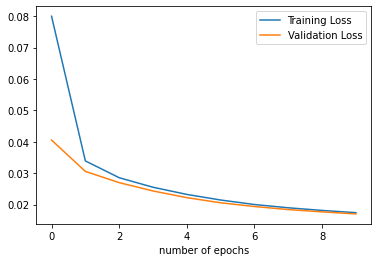

Epoch: 1 / 10, Train_loss: 0.0610, Val_loss: 0.0350, Time_taken: 0.69 mins
Epoch: 2 / 10, Train_loss: 0.0323, Val_loss: 0.0310, Time_taken: 1.35 mins
Epoch: 3 / 10, Train_loss: 0.0302, Val_loss: 0.0294, Time_taken: 2.04 mins
Epoch: 4 / 10, Train_loss: 0.0290, Val_loss: 0.0285, Time_taken: 2.70 mins
Epoch: 5 / 10, Train_loss: 0.0283, Val_loss: 0.0278, Time_taken: 3.40 mins
Epoch: 6 / 10, Train_loss: 0.0275, Val_loss: 0.0270, Time_taken: 4.07 mins
Epoch: 7 / 10, Train_loss: 0.0267, Val_loss: 0.0262, Time_taken: 4.75 mins
Epoch: 8 / 10, Train_loss: 0.0259, Val_loss: 0.0255, Time_taken: 5.44 mins
Epoch: 9 / 10, Train_loss: 0.0253, Val_loss: 0.0250, Time_taken: 6.11 mins
Epoch: 10 / 10, Train_loss: 0.0250, Val_loss: 0.0247, Time_taken: 6.80 mins


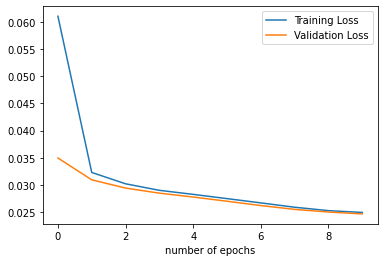

Epoch: 1 / 10, Train_loss: 0.0962, Val_loss: 0.0317, Time_taken: 12.44 mins
Epoch: 2 / 10, Train_loss: 0.0243, Val_loss: 0.0209, Time_taken: 24.85 mins
Epoch: 3 / 10, Train_loss: 0.0191, Val_loss: 0.0178, Time_taken: 37.25 mins
Epoch: 4 / 10, Train_loss: 0.0168, Val_loss: 0.0161, Time_taken: 49.65 mins
Epoch: 5 / 10, Train_loss: 0.0154, Val_loss: 0.0149, Time_taken: 62.04 mins
Epoch: 6 / 10, Train_loss: 0.0144, Val_loss: 0.0140, Time_taken: 74.46 mins
Epoch: 7 / 10, Train_loss: 0.0136, Val_loss: 0.0133, Time_taken: 86.82 mins
Epoch: 8 / 10, Train_loss: 0.0130, Val_loss: 0.0128, Time_taken: 99.25 mins
Epoch: 9 / 10, Train_loss: 0.0126, Val_loss: 0.0124, Time_taken: 111.93 mins
Epoch: 10 / 10, Train_loss: 0.0122, Val_loss: 0.0121, Time_taken: 124.32 mins


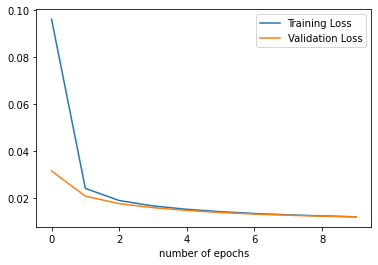

Epoch: 1 / 10, Train_loss: 0.0508, Val_loss: 0.0290, Time_taken: 12.44 mins
Epoch: 2 / 10, Train_loss: 0.0270, Val_loss: 0.0258, Time_taken: 24.82 mins
Epoch: 3 / 10, Train_loss: 0.0251, Val_loss: 0.0246, Time_taken: 37.23 mins
Epoch: 4 / 10, Train_loss: 0.0242, Val_loss: 0.0240, Time_taken: 49.59 mins
Epoch: 5 / 10, Train_loss: 0.0238, Val_loss: 0.0236, Time_taken: 61.97 mins
Epoch: 6 / 10, Train_loss: 0.0235, Val_loss: 0.0233, Time_taken: 74.61 mins
Epoch: 7 / 10, Train_loss: 0.0232, Val_loss: 0.0231, Time_taken: 86.97 mins
Epoch: 8 / 10, Train_loss: 0.0231, Val_loss: 0.0230, Time_taken: 99.46 mins
Epoch: 9 / 10, Train_loss: 0.0229, Val_loss: 0.0228, Time_taken: 111.90 mins
Epoch: 10 / 10, Train_loss: 0.0228, Val_loss: 0.0227, Time_taken: 123.95 mins


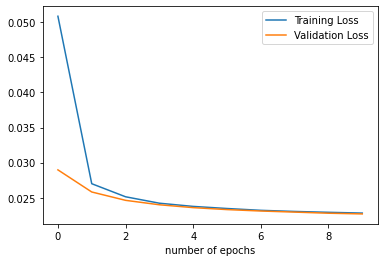

模型訓練已結束，總共花費15716.792338609695


In [14]:
# 載入訓練好的模型
#model_mnist = VGG16(input_size=(1, 32, 32), num_classes=10)
#model_mnist.load_state_dict(torch.load("best_VGG16_mnist.pth", map_location=device))
#model_fmnist = VGG16(input_size=(1, 32, 32), num_classes=10)
#model_fmnist.load_state_dict(torch.load("best_VGG16_fmnist.pth", map_location=device))
model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_mnist.load_state_dict(torch.load("resnet18_mnist.pth", map_location=device))
model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_fmnist.load_state_dict(torch.load("resnet18_fmnist.pth", map_location=device))
#model_mnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
#model_mnist.load_state_dict(torch.load("simple_cnn_gelu_mnist.pth", map_location=device))
#model_fmnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
#model_fmnist.load_state_dict(torch.load("simple_cnn_gelu_fmnist.pth", map_location=device))

# 載入資料
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()
train_size_mnist = int(0.8 * len(train_loader_mnist.dataset))
val_size_mnist = len(train_loader_mnist.dataset) - train_size_mnist
train_dataset_mnist, val_dataset_mnist = random_split(train_loader_mnist.dataset, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_dataset_mnist, batch_size=128, shuffle=False, num_workers=2)

train_size_fmnist = int(0.8 * len(train_loader_fmnist.dataset))
val_size_fmnist = len(train_loader_fmnist.dataset) - train_size_fmnist
train_dataset_fmnist, val_dataset_fmnist = random_split(train_loader_fmnist.dataset, [train_size_fmnist, val_size_fmnist])
train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_fmnist = DataLoader(val_dataset_fmnist, batch_size=128, shuffle=False, num_workers=2)


# 載入資料
#adv_train_mnist_fgsm, original_train_mnist_fgsm, train_labels_mnist_fgsm = torch.load("adv_train_mnist_fgsm.pt")
#adv_test_mnist_fgsm, original_test_mnist_fgsm, test_labels_mnist_fgsm = torch.load("adv_test_mnist_fgsm.pt")
#adv_train_mnist_pgd, original_train_mnist_pgd, train_labels_mnist_pgd = torch.load("adv_train_mnist_pgd.pt")
#adv_test_mnist_pgd, original_test_mnist_pgd, test_labels_mnist_pgd = torch.load("adv_test_mnist_pgd.pt")

#adv_train_fmnist_fgsm, original_train_fmnist_fgsm, train_labels_fmnist_fgsm = torch.load("adv_train_fmnist_fgsm.pt")
#adv_test_fmnist_fgsm, original_test_fmnist_fgsm, test_labels_fmnist_fgsm = torch.load("adv_test_fmnist_fgsm.pt")
#adv_train_fmnist_pgd, original_train_fmnist_pgd, train_labels_fmnist_pgd = torch.load("adv_train_fmnist_pgd.pt")
#adv_test_fmnist_pgd, original_test_fmnist_pgd, test_labels_fmnist_pgd = torch.load("adv_test_fmnist_pgd.pt")

# 將原始資料和對抗樣本結合 (MNIST 和 FashionMNIST)
#train_data = torch.cat([
    #original_train_mnist_fgsm, adv_train_mnist_fgsm, original_train_mnist_pgd, adv_train_mnist_pgd,
    #original_train_fmnist_fgsm, adv_train_fmnist_fgsm, original_train_fmnist_pgd, adv_train_fmnist_pgd
#], dim=0)

#test_data = torch.cat([
    #original_test_mnist_fgsm, adv_test_mnist_fgsm, original_test_mnist_pgd, adv_test_mnist_pgd,
    #original_test_fmnist_fgsm, adv_test_fmnist_fgsm, original_test_fmnist_pgd, adv_test_fmnist_pgd
#], dim=0)

# 建立 DataLoader
#train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=128, shuffle=True)
#test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=128, shuffle=False)

# 建立模型
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"CUDA 可用，正在使用 GPU：{torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("CUDA 不可用，正在使用 CPU")
convAE = ConvAutoencoder_GELU(device).to(device)
summary(convAE, (1, 32, 32))

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(convAE.parameters(), lr=0.001)
system_start=time.time()
num_epochs = 10
train(model_mnist, num_epochs, 'fgsm', train_loader_mnist, val_loader_mnist, device, load_model=False, file_path='RESNET_fgsm_mnist_trained_autoencoder.pth')
convAE = ConvAutoencoder_GELU(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(convAE.parameters(), lr=0.001)
train(model_fmnist, num_epochs, 'fgsm', train_loader_fmnist, val_loader_fmnist, device, load_model=False, file_path='RESNET_fgsm_fmnist_trained_autoencoder.pth')
convAE = ConvAutoencoder_GELU(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(convAE.parameters(), lr=0.001)
train(model_mnist, num_epochs, 'pgd', train_loader_mnist, val_loader_mnist, device, load_model=False, file_path='RESNET_pgd_mnist_trained_autoencoder.pth')
convAE = ConvAutoencoder_GELU(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(convAE.parameters(), lr=0.001)
train(model_fmnist, num_epochs, 'pgd', train_loader_fmnist, val_loader_fmnist, device, load_model=False, file_path='RESNET_pgd_fmnist_trained_autoencoder.pth')

print(f"模型訓練已結束，總共花費{time.time()-system_start}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
              GELU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
       BatchNorm2d-4             [-1, 16, 8, 8]              32
              GELU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
            Conv2d-8              [-1, 4, 3, 3]             132
            Conv2d-9              [-1, 4, 3, 3]             132
           Conv2d-10             [-1, 32, 3, 3]           1,056
    SelfAttention-11             [-1, 32, 3, 3]               0
          Flatten-12                  [-1, 288]               0
           Linear-13                  [-1, 128]          36,992
             GELU-14                  [

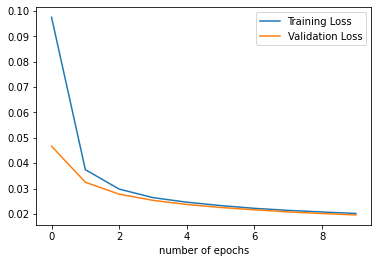

Epoch: 1 / 10, Train_loss: 0.0584, Val_loss: 0.0341, Time_taken: 0.80 mins
Epoch: 2 / 10, Train_loss: 0.0321, Val_loss: 0.0309, Time_taken: 1.58 mins
Epoch: 3 / 10, Train_loss: 0.0302, Val_loss: 0.0295, Time_taken: 2.37 mins
Epoch: 4 / 10, Train_loss: 0.0290, Val_loss: 0.0285, Time_taken: 3.15 mins
Epoch: 5 / 10, Train_loss: 0.0281, Val_loss: 0.0277, Time_taken: 3.94 mins
Epoch: 6 / 10, Train_loss: 0.0274, Val_loss: 0.0270, Time_taken: 4.72 mins
Epoch: 7 / 10, Train_loss: 0.0267, Val_loss: 0.0264, Time_taken: 5.50 mins
Epoch: 8 / 10, Train_loss: 0.0261, Val_loss: 0.0259, Time_taken: 6.27 mins
Epoch: 9 / 10, Train_loss: 0.0257, Val_loss: 0.0254, Time_taken: 7.02 mins
Epoch: 10 / 10, Train_loss: 0.0253, Val_loss: 0.0250, Time_taken: 7.79 mins


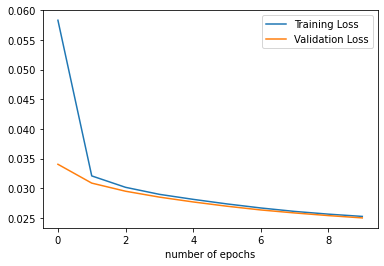

Epoch: 1 / 10, Train_loss: 0.0921, Val_loss: 0.0344, Time_taken: 12.33 mins
Epoch: 2 / 10, Train_loss: 0.0261, Val_loss: 0.0222, Time_taken: 24.62 mins
Epoch: 3 / 10, Train_loss: 0.0201, Val_loss: 0.0188, Time_taken: 36.87 mins
Epoch: 4 / 10, Train_loss: 0.0176, Val_loss: 0.0168, Time_taken: 49.19 mins
Epoch: 5 / 10, Train_loss: 0.0161, Val_loss: 0.0155, Time_taken: 61.47 mins
Epoch: 6 / 10, Train_loss: 0.0150, Val_loss: 0.0146, Time_taken: 73.98 mins
Epoch: 7 / 10, Train_loss: 0.0142, Val_loss: 0.0139, Time_taken: 86.28 mins
Epoch: 8 / 10, Train_loss: 0.0136, Val_loss: 0.0133, Time_taken: 98.57 mins
Epoch: 9 / 10, Train_loss: 0.0131, Val_loss: 0.0129, Time_taken: 110.89 mins
Epoch: 10 / 10, Train_loss: 0.0127, Val_loss: 0.0126, Time_taken: 123.15 mins


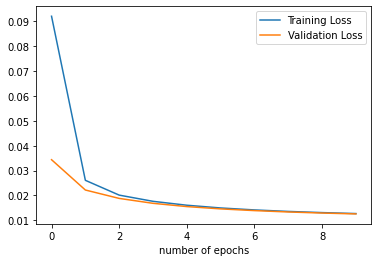

Epoch: 1 / 10, Train_loss: 0.0661, Val_loss: 0.0303, Time_taken: 12.29 mins
Epoch: 2 / 10, Train_loss: 0.0271, Val_loss: 0.0257, Time_taken: 24.62 mins
Epoch: 3 / 10, Train_loss: 0.0251, Val_loss: 0.0247, Time_taken: 37.35 mins
Epoch: 4 / 10, Train_loss: 0.0243, Val_loss: 0.0241, Time_taken: 49.84 mins
Epoch: 5 / 10, Train_loss: 0.0239, Val_loss: 0.0237, Time_taken: 62.22 mins
Epoch: 6 / 10, Train_loss: 0.0235, Val_loss: 0.0234, Time_taken: 74.45 mins
Epoch: 7 / 10, Train_loss: 0.0233, Val_loss: 0.0231, Time_taken: 86.65 mins
Epoch: 8 / 10, Train_loss: 0.0231, Val_loss: 0.0230, Time_taken: 98.95 mins
Epoch: 9 / 10, Train_loss: 0.0229, Val_loss: 0.0228, Time_taken: 111.21 mins
Epoch: 10 / 10, Train_loss: 0.0228, Val_loss: 0.0227, Time_taken: 123.45 mins


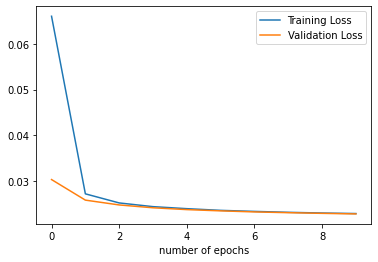

模型訓練已結束，總共花費15733.851051092148


In [15]:
# 載入訓練好的模型
num_classes = 10
#model_mnist = VGG16(input_size=(1, 32, 32), num_classes=10)
#model_mnist.load_state_dict(torch.load("best_VGG16_mnist.pth", map_location=device))
#model_fmnist = VGG16(input_size=(1, 32, 32), num_classes=10)
#model_fmnist.load_state_dict(torch.load("best_VGG16_fmnist.pth", map_location=device))
model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_mnist.load_state_dict(torch.load("resnet18_mnist.pth", map_location=device))
model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_fmnist.load_state_dict(torch.load("resnet18_fmnist.pth", map_location=device))
#model_mnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
#model_mnist.load_state_dict(torch.load("simple_cnn_gelu_mnist.pth", map_location=device))
#model_fmnist = SimpleCNN_GELU(num_classes=num_classes, input_channels=input_channels).to(device)
#model_fmnist.load_state_dict(torch.load("simple_cnn_gelu_fmnist.pth", map_location=device))

# 載入資料
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()
train_size_mnist = int(0.8 * len(train_loader_mnist.dataset))
val_size_mnist = len(train_loader_mnist.dataset) - train_size_mnist
train_dataset_mnist, val_dataset_mnist = random_split(train_loader_mnist.dataset, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_dataset_mnist, batch_size=128, shuffle=False, num_workers=2)

train_size_fmnist = int(0.8 * len(train_loader_fmnist.dataset))
val_size_fmnist = len(train_loader_fmnist.dataset) - train_size_fmnist
train_dataset_fmnist, val_dataset_fmnist = random_split(train_loader_fmnist.dataset, [train_size_fmnist, val_size_fmnist])
train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_fmnist = DataLoader(val_dataset_fmnist, batch_size=128, shuffle=False, num_workers=2)

CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
summary(CSAAE, (1, 32, 32))

criterion = nn.MSELoss()
optimizer = optim.Adam(CSAAE.parameters(), lr=0.001)
system_start=time.time()
num_epochs = 10

train_CSAAE(model_mnist, num_epochs, 'fgsm', train_loader_mnist, val_loader_mnist, device, load_model=False, file_path='RESNET_fgsm_mnist_trained_self-attention_autoencoder.pth')
CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(CSAAE.parameters(), lr=0.001)
train_CSAAE(model_fmnist, num_epochs, 'fgsm', train_loader_fmnist, val_loader_fmnist, device, load_model=False, file_path='RESNET_fgsm_fmnist_trained_self-attention_autoencoder.pth')
CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(CSAAE.parameters(), lr=0.001)
train_CSAAE(model_mnist, num_epochs, 'pgd', train_loader_mnist, val_loader_mnist, device, load_model=False, file_path='RESNET_pgd_mnist_trained_self-attention_autoencoder.pth')
CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(CSAAE.parameters(), lr=0.001)
train_CSAAE(model_fmnist, num_epochs, 'pgd', train_loader_fmnist, val_loader_fmnist, device, load_model=False, file_path='RESNET_pgd_fmnist_trained_self-attention_autoencoder.pth')

print(f"模型訓練已結束，總共花費{time.time()-system_start}")

In [17]:
def to_numpy_array(tensor):
    '''Convert torch.Tensor to np.ndarray'''
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

def visualise(model, autoencoder, val_loader, attack_type, eps_fgsm=0.6, eps_pgd=0.15, alpha=1e-2, num_iter=40):
    count = 0
    for i, (imgs, labels) in enumerate(val_loader):
        if count > 4:
            break
        if i % 3 == 0:
            count += 1
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs = fgsm_attack(model, imgs, device,labels, eps_fgsm)
            else:
                adv_imgs = pgd_attack(model, imgs, device, labels, eps_pgd, alpha, num_iter)

            adv_imgs = adv_imgs.to(device)

            with torch.no_grad():
                rec_imgs = autoencoder.forward(adv_imgs)

            imgs, adv_imgs, rec_imgs = to_numpy_array(imgs[0]), to_numpy_array(adv_imgs[0]), to_numpy_array(rec_imgs[0])

            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax1.imshow(adv_imgs)
            ax1.set_title("Adversarial Image")
            ax2.imshow(rec_imgs)
            ax2.set_title("Recreated Image")
            ax3.imshow(imgs)
            ax3.set_title("Original Image")
            plt.show()

mnist fgsm CSAAE visualization


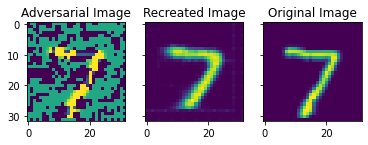

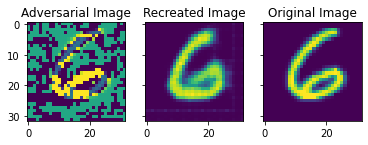

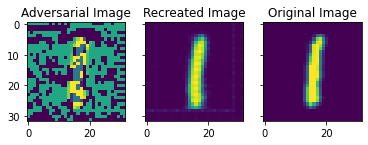

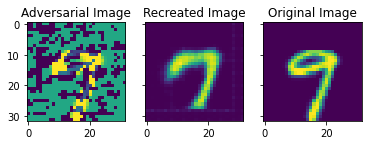

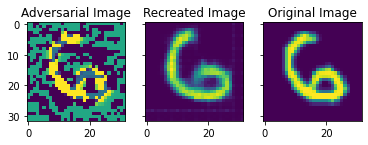

mnist pgd CSAAE visualization


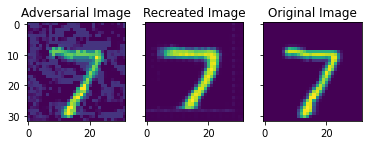

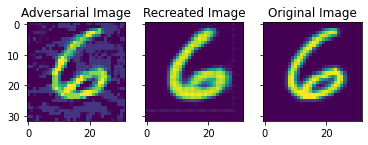

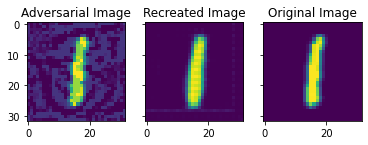

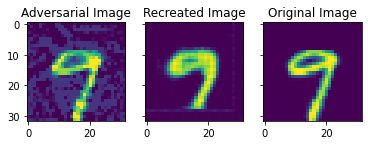

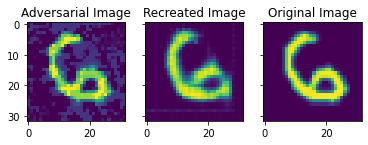

mnist fgsm CAE visualization


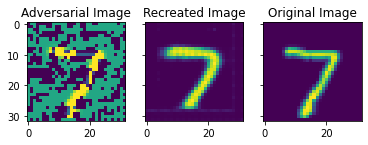

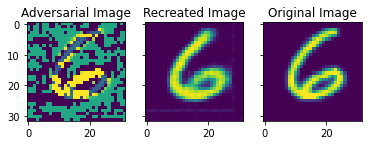

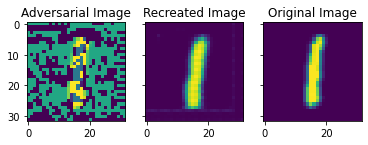

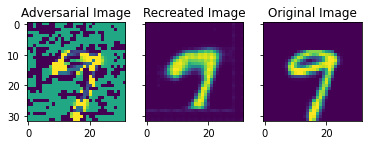

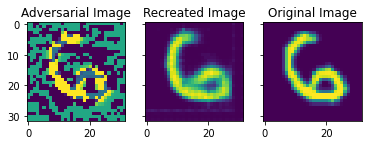

mnist pgd CAE visualization


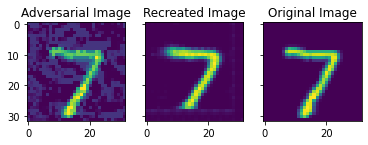

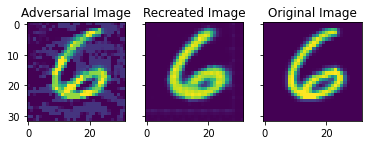

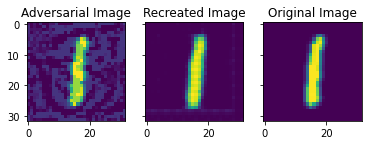

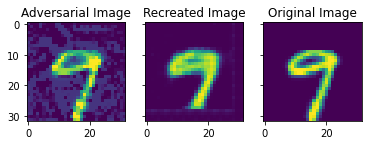

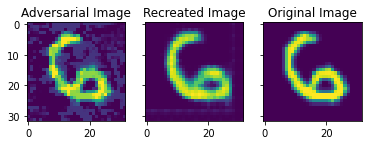

fmnist fgsm CSAAE visualization


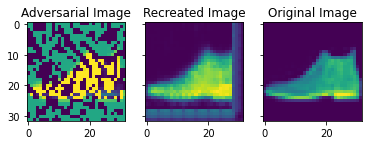

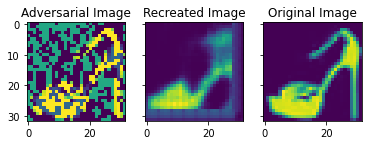

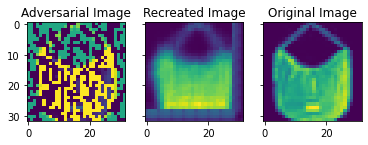

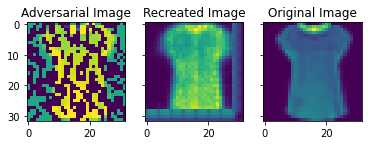

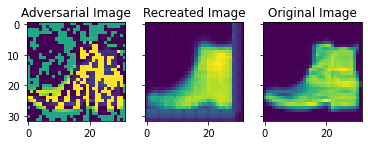

fmnist pgd CSAAE visualization


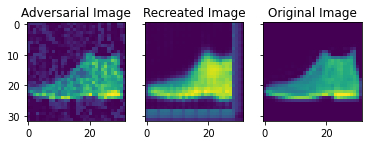

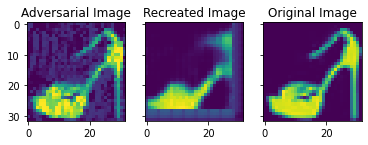

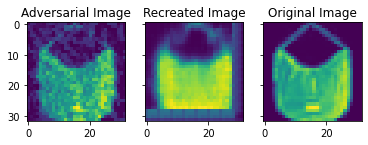

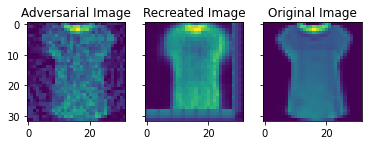

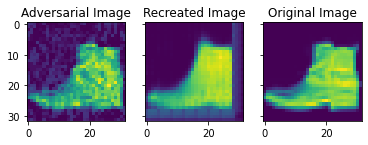

fmnist fgsm CAE visualization


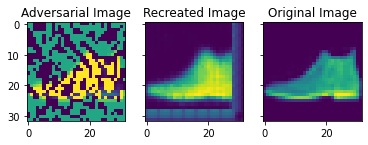

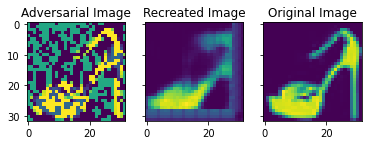

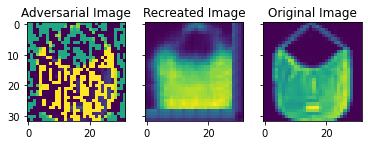

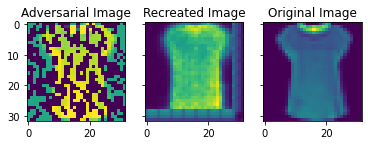

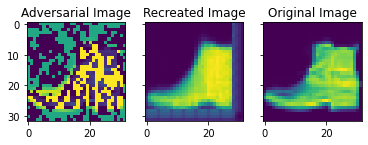

fmnist pgd CAE visualization


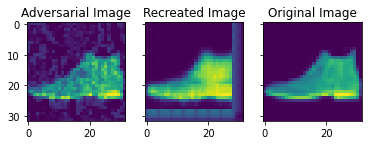

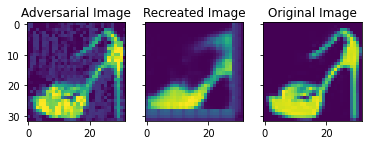

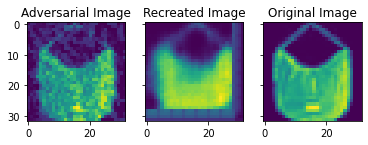

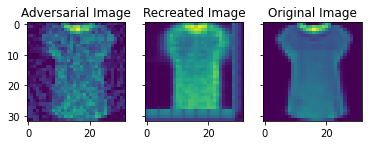

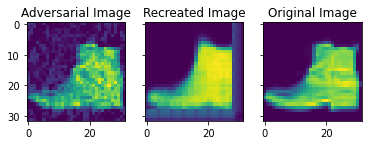

In [19]:
# 載入訓練好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_mnist = VGG16(input_size=(1, 32, 32), num_classes=10).to(device)
#model_mnist.load_state_dict(torch.load("best_VGG16_mnist.pth", map_location=device))
#model_fmnist = VGG16(input_size=(1, 32, 32), num_classes=10).to(device)
#model_fmnist.load_state_dict(torch.load("best_VGG16_fmnist.pth", map_location=device))
model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_mnist.load_state_dict(torch.load("resnet18_mnist.pth", map_location=device))
model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_fmnist.load_state_dict(torch.load("resnet18_fmnist.pth", map_location=device))

# 載入資料
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()

train_size_mnist = int(0.8 * len(train_loader_mnist.dataset))
val_size_mnist = len(train_loader_mnist.dataset) - train_size_mnist
train_dataset_mnist, val_dataset_mnist = random_split(train_loader_mnist.dataset, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_dataset_mnist, batch_size=128, shuffle=False, num_workers=2)

train_size_fmnist = int(0.8 * len(train_loader_fmnist.dataset))
val_size_fmnist = len(train_loader_fmnist.dataset) - train_size_fmnist
train_dataset_fmnist, val_dataset_fmnist = random_split(train_loader_fmnist.dataset, [train_size_fmnist, val_size_fmnist])
train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_fmnist = DataLoader(val_dataset_fmnist, batch_size=128, shuffle=False, num_workers=2)

CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
CAE = ConvAutoencoder_GELU(device).to(device)

# 可視化 MNIST 測試集
print('mnist fgsm CSAAE visualization')
checkpoint = torch.load("RESNET_fgsm_mnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
visualise(model_mnist, CSAAE, test_loader_mnist, 'fgsm')
print('mnist pgd CSAAE visualization')
checkpoint = torch.load("RESNET_pgd_mnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
visualise(model_mnist, CSAAE, test_loader_mnist, 'pgd')
print('mnist fgsm CAE visualization')
checkpoint = torch.load("RESNET_fgsm_mnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
visualise(model_mnist, CAE, test_loader_mnist, 'fgsm')
print('mnist pgd CAE visualization')
checkpoint = torch.load("RESNET_pgd_mnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
visualise(model_mnist, CAE, test_loader_mnist, 'pgd')

# 可視化 FashionMNIST 測試集
print('fmnist fgsm CSAAE visualization')
checkpoint = torch.load("RESNET_fgsm_fmnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
visualise(model_fmnist, CSAAE, test_loader_fmnist, 'fgsm')
print('fmnist pgd CSAAE visualization')
checkpoint = torch.load("RESNET_pgd_fmnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
visualise(model_fmnist, CSAAE, test_loader_fmnist, 'pgd')
print('fmnist fgsm CAE visualization')
checkpoint = torch.load("RESNET_fgsm_fmnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
visualise(model_fmnist, CAE, test_loader_fmnist, 'fgsm')
print('fmnist pgd CAE visualization')
checkpoint = torch.load("RESNET_pgd_fmnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
visualise(model_fmnist, CAE, test_loader_fmnist, 'pgd')

In [18]:
def test(model, autoencoder, test_loader, attack_type, eps_fgsm=0.6, eps_pgd=0.15, alpha=1e-2, num_iter=40):
    
    correct, total = 0, 0
    autoencoder.eval()
    model.eval()
    tot_time = 0

    for _, (imgs, labels) in enumerate(test_loader):
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        if attack_type == 'fgsm':
            adv_imgs = fgsm_attack(model, imgs, device, labels, eps_fgsm)
        else:
            adv_imgs = pgd_attack(model, imgs, device, labels, eps_pgd, alpha, num_iter)

        adv_imgs = adv_imgs.to(device)
        
        time_comp = time.time()

        rec_imgs = autoencoder.forward(adv_imgs)

        y_preds = model(rec_imgs).argmax(dim=1)
        correct += (y_preds == labels).sum().item()
        total += labels.size(0)
        
        tot_time += (time.time() - time_comp)

    print("Test Accuracy: {}".format(correct / total))
    print(f'Time taken for defense against a single instance of attack: {(tot_time)/10000:.4f} sec')
    print(f'Total time taken: {tot_time:.4f} sec')

In [20]:
# 載入訓練好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_mnist.load_state_dict(torch.load("resnet18_mnist.pth", map_location=device))
model_fmnist = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, input_channels=1).to(device)
model_fmnist.load_state_dict(torch.load("resnet18_fmnist.pth", map_location=device))

# 載入資料
train_loader_mnist, test_loader_mnist, train_loader_fmnist, test_loader_fmnist = get_mnist_loaders()

train_size_mnist = int(0.8 * len(train_loader_mnist.dataset))
val_size_mnist = len(train_loader_mnist.dataset) - train_size_mnist
train_dataset_mnist, val_dataset_mnist = random_split(train_loader_mnist.dataset, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_dataset_mnist, batch_size=128, shuffle=False, num_workers=2)

train_size_fmnist = int(0.8 * len(train_loader_fmnist.dataset))
val_size_fmnist = len(train_loader_fmnist.dataset) - train_size_fmnist
train_dataset_fmnist, val_dataset_fmnist = random_split(train_loader_fmnist.dataset, [train_size_fmnist, val_size_fmnist])
train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_fmnist = DataLoader(val_dataset_fmnist, batch_size=128, shuffle=False, num_workers=2)

CSAAE = ConvSelfAttentionAutoencoder(device).to(device)
CAE = ConvAutoencoder_GELU(device).to(device)

checkpoint = torch.load("RESNET_fgsm_mnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
checkpoint = torch.load("RESNET_fgsm_mnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
print('CSAAE fgsm mnist evaluation')
test(model_mnist, CSAAE, test_loader_mnist, 'fgsm')
print('CAE fgsm mnist evaluation')
test(model_mnist, CAE, test_loader_mnist, 'fgsm')

checkpoint = torch.load("RESNET_pgd_mnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
checkpoint = torch.load("RESNET_pgd_mnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
print('CSAAE pgd mnist evaluation')
test(model_mnist, CSAAE, test_loader_mnist, 'pgd')
print('CAE pgd mnist evaluation')
test(model_mnist, CAE, test_loader_mnist, 'pgd')

checkpoint = torch.load("RESNET_fgsm_fmnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
checkpoint = torch.load("RESNET_fgsm_fmnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
print('CSAAE fgsm fmnist evaluation')
test(model_fmnist, CSAAE, test_loader_fmnist, 'fgsm')
print('CAE fgsm fmnist evaluation')
test(model_fmnist, CAE, test_loader_fmnist, 'fgsm')

checkpoint = torch.load("RESNET_pgd_fmnist_trained_self-attention_autoencoder.pth", map_location=device)
CSAAE.load_state_dict(checkpoint['CSAAE_state_dict'])
checkpoint = torch.load("RESNET_pgd_fmnist_trained_autoencoder.pth", map_location=device)
CAE.load_state_dict(checkpoint['convAE_state_dict'])
print('CSAAE pgd fmnist evaluation')
test(model_fmnist, CSAAE, test_loader_fmnist, 'pgd')
print('CAE pgd fmnist evaluation')
test(model_fmnist, CAE, test_loader_fmnist, 'pgd')

CSAAE fgsm mnist evaluation
Test Accuracy: 0.7866
Time taken for defense against a single instance of attack: 0.0002 sec
Total time taken: 1.5449 sec
CAE fgsm mnist evaluation
Test Accuracy: 0.8292
Time taken for defense against a single instance of attack: 0.0001 sec
Total time taken: 1.3213 sec
CSAAE pgd mnist evaluation
Test Accuracy: 0.9256
Time taken for defense against a single instance of attack: 0.0002 sec
Total time taken: 1.6416 sec
CAE pgd mnist evaluation
Test Accuracy: 0.923
Time taken for defense against a single instance of attack: 0.0001 sec
Total time taken: 1.3727 sec
CSAAE fgsm fmnist evaluation
Test Accuracy: 0.6956
Time taken for defense against a single instance of attack: 0.0002 sec
Total time taken: 1.6737 sec
CAE fgsm fmnist evaluation
Test Accuracy: 0.6953
Time taken for defense against a single instance of attack: 0.0001 sec
Total time taken: 1.3115 sec
CSAAE pgd fmnist evaluation
Test Accuracy: 0.7177
Time taken for defense against a single instance of attac

In [32]:
def test_without_defense(model, test_loader, attack_type, eps_fgsm=0.6, eps_pgd=0.15, alpha=1e-2, num_iter=40):
    
    correct, total = 0, 0
    model.eval()
    tot_time = 0

    for _, (imgs, labels) in enumerate(test_loader):
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        if attack_type == 'fgsm':
            adv_imgs = fgsm_attack(model, imgs, device, labels, eps_fgsm)
        else:
            adv_imgs = pgd_attack(model, imgs, device, labels, eps_pgd, alpha, num_iter)

        adv_imgs = adv_imgs.to(device)
        
        time_comp = time.time()

        y_preds = model(adv_imgs).argmax(dim=1)
        correct += (y_preds == labels).sum().item()
        total += labels.size(0)
        
        tot_time += (time.time() - time_comp)

    print("Test Accuracy: {}".format(correct / total))
    print(f'Time taken for defense against a single instance of attack: {(tot_time)/10000:.4f} sec')
    print(f'Total time taken: {tot_time:.4f} sec')

In [33]:
print('pgd fmnist evaluation')
test_without_defense(model_fmnist, test_loader_fmnist, 'pgd')
print('fgsm fmnist evaluation')
test_without_defense(model_fmnist, test_loader_fmnist, 'fgsm')
print('pgd mnist evaluation')
test_without_defense(model_mnist, test_loader_mnist, 'pgd')
print('fgsm mnist evaluation')
test_without_defense(model_mnist, test_loader_mnist, 'fgsm')

pgd fmnist evaluation
Test Accuracy: 0.0098
Time taken for defense against a single instance of attack: 0.0014 sec
Total time taken: 13.5333 sec
fgsm fmnist evaluation
Test Accuracy: 0.1388
Time taken for defense against a single instance of attack: 0.0003 sec
Total time taken: 2.9555 sec
pgd mnist evaluation
Test Accuracy: 0.0325
Time taken for defense against a single instance of attack: 0.0014 sec
Total time taken: 13.5145 sec
fgsm mnist evaluation
Test Accuracy: 0.1902
Time taken for defense against a single instance of attack: 0.0003 sec
Total time taken: 2.8753 sec
